In [6]:
## Imports

import sys
import os
import time
import math
import random
import pdb
import h5py

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
# Plotting import
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import the utils for plotting the metrics
from plot_utils import plot_utils
from plot_utils import notebook_utils_2

from sklearn.metrics import roc_curve, auc

# Dictionary mapping the ordinal labels to particle types 
LABEL_DICT = {0:"gamma", 1:"e", 2:"mu"}
softmax_index_dict = {value:key for key, value in LABEL_DICT.items()}

# Fix the colour scheme for each particle type
COLOR_DICT = {"gamma":"red", "e":"blue", "mu":"green"}

label_0 = "e"
label_1 = "mu"
min_energy = 0
max_energy = 1000

In [23]:
# Plot multiple ROC curves on the same figure
def plot_multiple_ROC(fprs, tprs, thresholds, label_0, label_1, lbound, ubound):
    
    min_energy = 0
    max_energy = 1000
    
    fig, ax = plt.subplots(figsize=(16,9),facecolor="w")
    ax.tick_params(axis="both", labelsize=20)
    
    model_colors = [np.random.rand(3,) for i in fprs]
    model_colors = ["red", "blue"]
    
    for j in np.arange(len(fprs)):
        fpr = fprs[j]
        tpr = tprs[j]
        threshold = thresholds[j]
     
        roc_auc = auc(fpr, tpr)

        inv_fpr = []
        for i in fpr:
            inv_fpr.append(1/i) if i != 0 else inv_fpr.append(1/1e-5)

        tnr = 1. - fpr

        # TNR vs TPR plot

        ax.plot(tpr, inv_fpr, color=model_colors[j],
                 label=r"${1:0.3f}$: $\{0}$, AUC ${1:0.3f}$".format((j+1),label_0, roc_auc) if label_0 is not "e" else r"${0}$, AUC ${1:0.3f}$".format(label_0, roc_auc),
                 linewidth=1.0, marker=".", markersize=4.0, markerfacecolor=model_colors[j])

        # Show coords of individual points near x = 0.2, 0.5, 0.8
        todo = {0.2: True, 0.5: True, 0.8: True}
        for xy in zip(tpr, inv_fpr, tnr):
            xy = (round(xy[0], 4), round(xy[1], 4), round(xy[2], 4))
            xy_plot = (round(xy[0], 4), round(xy[1], 4))
            for point in todo.keys():
                if xy[0] >= point and todo[point]:
                    ax.annotate('(%s, %s, %s)' % xy, xy=xy_plot, textcoords='data', fontsize=18, bbox=dict(boxstyle="square", fc="w"))
                    todo[point] = False

            ax.grid(True, which='both', color='grey')
            xlabel = r"$\{0}$ signal efficiency".format(label_0) if label_0 is not "e" else r"${0}$ signal efficiency".format(label_0)
            ylabel = r"$\{0}$ background rejection".format(label_1) if label_1 is not "e" else r"${0}$ background rejection".format(label_1)

            ax.set_xlabel(xlabel, fontsize=20) 
            ax.set_ylabel(ylabel, fontsize=20)

            ax.set_title(r"${0} \leq E < {1}$".format(round(lbound,2), round(ubound,2)), fontsize=20)
            ax.legend(loc="upper right", prop={"size":20})

            plt.margins(0.1)
        plt.yscale("log")
        
    plt.savefig(('/home/ttuinstr/VAE/Comparing_ResNet_and_FiTQun/ROC_comparison.png'), bbox_inches='tight')    
    
    plt.show()

    plt.clf() # Clear the current figure
    plt.close() # Close the opened window
        
        
    return fpr, tpr, threshold, roc_auc

In [24]:
# Function to plot a confusion matrix
def plot_confusion_matrix(labels, predictions, class_names):
    
    """
    plot_confusion_matrix(labels, predictions, class_names)
    
    Purpose : Plot the confusion matrix for a given energy interval
    
    Args: labels              ... 1D array of true label value, the length = sample size
          predictions         ... 1D array of predictions, the length = sample size
          class_names         ... 1D array of string label for classification targets, the length = number of categories
       
 
    """
    
    fig, ax = plt.subplots(figsize=(12,8),facecolor='w')
    num_labels = len(class_names)
    max_value = np.max([np.max(np.unique(labels)),np.max(np.unique(labels))])
    assert max_value < num_labels
    mat,_,_,im = ax.hist2d(predictions, labels,
                           bins=(num_labels,num_labels),
                           range=((-0.5,num_labels-0.5),(-0.5,num_labels-0.5)),cmap=plt.cm.Blues)

    # Normalize the confusion matrix
    mat = mat.astype("float") / mat.sum(axis=0)

    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=20) 
        
    ax.set_xticks(np.arange(num_labels))
    ax.set_yticks(np.arange(num_labels))
    ax.set_xticklabels(class_names,fontsize=20)
    ax.set_yticklabels(class_names,fontsize=20)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    ax.set_xlabel('Prediction',fontsize=20)
    ax.set_ylabel('True Label',fontsize=20)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ax.text(i,j, r"${0:0.3f}$".format(mat[i,j]),
                    ha="center", va="center", fontsize=20,
                    color="white" if mat[i,j] > (0.5*mat.max()) else "black")
    plt.show()

In [25]:
# Get original h5 file info

# Import test events from h5 file
filtered_index = "/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs.npz"
filtered_indices = np.load(filtered_index, allow_pickle=True)
test_filtered_indices = filtered_indices['test_idxs']
print(test_filtered_indices.shape)

original_data_path = "/data/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M.h5"
f = h5py.File(original_data_path, "r")

hdf5_event_data = (f["event_data"])
original_eventdata = np.memmap(original_data_path, mode="r", shape=hdf5_event_data.shape,
                                    offset=hdf5_event_data.id.get_offset(), dtype=hdf5_event_data.dtype)

original_eventids = np.array(f['event_ids'])
original_rootfiles = np.array(f['root_files'])
original_energies = np.array(f['energies'])
original_positions = np.array(f['positions'])
original_angles = np.array(f['angles'])
original_labels = np.array(f['labels'])

#filtered_eventdata = original_eventdata[test_filtered_indices]
filtered_eventids = original_eventids[test_filtered_indices]
filtered_rootfiles = original_rootfiles[test_filtered_indices]
filtered_energies = original_energies[test_filtered_indices]
filtered_positions = original_positions[test_filtered_indices]
filtered_angles = original_angles[test_filtered_indices]
filtered_labels = original_labels[test_filtered_indices]

(3351020,)


In [26]:
# Map ResNet results to fiTQun events

# Map ResNet results to original h5 file events
mapping_indices = np.load('/home/ttuinstr/VAE/Comparing_ResNet_and_FiTQun/map_indices_resnet.npz')
mapping_indices = mapping_indices['arr_0'].astype(int)

res_softmaxes = np.load('/home/ttuinstr/VAE/Comparing_ResNet_and_FiTQun/resnet_softmaxes.npz')
res_softmaxes = res_softmaxes['arr_0']
res_energies = np.load('/home/ttuinstr/VAE/Comparing_ResNet_and_FiTQun/resnet_energies.npz')
res_energies = res_energies['arr_0']
res_predictedlabels = np.load('/home/ttuinstr/VAE/Comparing_ResNet_and_FiTQun/resnet_predictedlabels.npz')
res_predictedlabels = res_predictedlabels['arr_0']

res_softmaxes = res_softmaxes[mapping_indices]
res_energies = res_energies[mapping_indices]
res_predictedlabels = res_predictedlabels[mapping_indices]

# Separate event types
e_test_indices = np.load('/home/ttuinstr/VAE/Comparing_ResNet_and_FiTQun/test_indices_e.npz')
e_test_indices = e_test_indices['arr_0'].astype(int)
mu_test_indices = np.load('/home/ttuinstr/VAE/Comparing_ResNet_and_FiTQun/test_indices_mu.npz')
mu_test_indices = mu_test_indices['arr_0'].astype(int)
gamma_test_indices = np.load('/home/ttuinstr/VAE/Comparing_ResNet_and_FiTQun/test_indices_gamma.npz')
gamma_test_indices = gamma_test_indices['arr_0'].astype(int)

e_predictedlabels = res_predictedlabels[e_test_indices]
mu_predictedlabels = res_predictedlabels[mu_test_indices]
gamma_predictedlabels = res_predictedlabels[gamma_test_indices]

e_softmaxes = res_softmaxes[e_test_indices]
mu_softmaxes = res_softmaxes[mu_test_indices]
gamma_softmaxes = res_softmaxes[gamma_test_indices]

e_labels = filtered_labels[e_test_indices]
mu_labels = filtered_labels[mu_test_indices]
gamma_labels = filtered_labels[gamma_test_indices]

e_rootfiles = filtered_rootfiles[e_test_indices]
mu_rootfiles = filtered_rootfiles[mu_test_indices]
gamma_rootfiles = filtered_rootfiles[gamma_test_indices]

e_eventids = filtered_eventids[e_test_indices]
mu_eventids = filtered_eventids[mu_test_indices]
gamma_eventids = filtered_eventids[gamma_test_indices]

e_positions = filtered_positions[e_test_indices]
mu_positions = filtered_positions[mu_test_indices]
gamma_positions = filtered_positions[gamma_test_indices]

e_angles = filtered_angles[e_test_indices]
mu_angles = filtered_angles[mu_test_indices]
gamma_angles = filtered_angles[gamma_test_indices]

e_energies = filtered_energies[e_test_indices]
mu_energies = filtered_energies[mu_test_indices]
gamma_energies = filtered_energies[gamma_test_indices]

# Match events in event types to fiTQun results
e_map_indices = np.load('/home/ttuinstr/VAE/Comparing_ResNet_and_FiTQun/map_indices_e_all.npz')
e_map_indices = e_map_indices['arr_0'].astype(int)
mu_map_indices = np.load('/home/ttuinstr/VAE/Comparing_ResNet_and_FiTQun/map_indices_mu_all.npz')
mu_map_indices = mu_map_indices['arr_0'].astype(int)
gamma_map_indices = np.load('/home/ttuinstr/VAE/Comparing_ResNet_and_FiTQun/map_indices_gamma_all.npz')
gamma_map_indices = gamma_map_indices['arr_0'].astype(int)

#e_eventdata = np.sum(original_eventdata[test_filtered_indices][e_test_indices][e_map_indices] > 0, (1,2,3))
#mu_eventdata = np.sum(original_eventdata[test_filtered_indices][mu_test_indices][mu_map_indices] > 0, (1,2,3))
#gamma_eventdata = np.sum(original_eventdata[test_filtered_indices][gamma_test_indices][gamma_map_indices] > 0, (1,2,3))

e_predictedlabels = e_predictedlabels[e_map_indices]
mu_predictedlabels = mu_predictedlabels[mu_map_indices]
gamma_predictedlabels = gamma_predictedlabels[gamma_map_indices]

e_softmaxes = e_softmaxes[e_map_indices]
mu_softmaxes = mu_softmaxes[mu_map_indices]
gamma_softmaxes = gamma_softmaxes[gamma_map_indices]

e_labels = e_labels[e_map_indices]
mu_labels = mu_labels[mu_map_indices]
gamma_labels = gamma_labels[gamma_map_indices]

e_positions = e_positions[e_map_indices]
mu_positions = mu_positions[mu_map_indices]
gamma_positions = gamma_positions[gamma_map_indices]

e_angles = e_angles[e_map_indices]
mu_angles = mu_angles[mu_map_indices]
gamma_angles = gamma_angles[gamma_map_indices]

e_energies = e_energies[e_map_indices]
mu_energies = mu_energies[mu_map_indices]
gamma_energies = gamma_energies[gamma_map_indices]

# For making ROC curves
e_softmax_0 = e_softmaxes[e_labels==softmax_index_dict[label_0]] 
mu_softmax_0 = mu_softmaxes[mu_labels==softmax_index_dict[label_0]]
gamma_softmax_0 = gamma_softmaxes[gamma_labels==softmax_index_dict[label_0]]

e_labels_0 = e_labels[e_labels==softmax_index_dict[label_0]] 
mu_labels_0 = mu_labels[mu_labels==softmax_index_dict[label_0]]
gamma_labels_0 = gamma_labels[gamma_labels==softmax_index_dict[label_0]]

e_softmax_1 = e_softmaxes[e_labels==softmax_index_dict[label_1]] 
mu_softmax_1 = mu_softmaxes[mu_labels==softmax_index_dict[label_1]]
gamma_softmax_1 = gamma_softmaxes[gamma_labels==softmax_index_dict[label_1]]

e_labels_1 = e_labels[e_labels==softmax_index_dict[label_1]] 
mu_labels_1 = mu_labels[mu_labels==softmax_index_dict[label_1]]
gamma_labels_1 = gamma_labels[gamma_labels==softmax_index_dict[label_1]]

total_softmax = np.concatenate((e_softmax_0, e_softmax_1, mu_softmax_0, mu_softmax_1), axis=0)
total_labels = np.concatenate((e_labels_0, e_labels_1, mu_labels_0, mu_labels_1), axis=0)


res_fpr, res_tpr, res_threshold = roc_curve(total_labels, total_softmax[:,softmax_index_dict[label_0]], pos_label=softmax_index_dict[label_0])

In [27]:
# Load the fiTQun results

# File paths for fiTQun results
fiTQun_e_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_e-.npz"
fiTQun_mu_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_mu-.npz"
fiTQun_gamma_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_gamma.npz"

# Load fiTQun results
f_e = np.load(fiTQun_e_path, allow_pickle=True)
f_mu = np.load(fiTQun_mu_path, allow_pickle=True)
f_gamma = np.load(fiTQun_gamma_path, allow_pickle=True)

list(f_e.keys())

# 'e_indices', 'mu_indices', and 'gamma_indices' can be used to remove events with a non-zero flag 
#  - comment out the lines where it is applied to the event properties to keep the flagged events included
#
# * A non-zero flag value usually implies that either the reconstruction is known to have failed 
#   or the particle exited the tank and so would not be included in actual physics analysis

e_flag = np.array(f_e['flag'])
e_indices = np.where((e_flag[:,0] == 0) & (e_flag[:,1] == 0))
e_flagindices = np.where((e_flag[:,0] != 0) | (e_flag[:,1] != 0))
mu_flag = np.array(f_mu['flag'])
mu_indices = np.where((mu_flag[:,0] == 0) & (mu_flag[:,1] == 0))
mu_flagindices = np.where((mu_flag[:,0] != 0) | (mu_flag[:,1] != 0))
gamma_flag = np.array(f_gamma['flag'])
gamma_indices = np.where((gamma_flag[:,0] == 0) & (gamma_flag[:,1] == 0))
gamma_flagindices = np.where((gamma_flag[:,0] != 0) | (gamma_flag[:,1] != 0))

# Get the filename for each event
e_file = np.array(f_e['filename'])
#e_file = e_file[e_indices]
mu_file = np.array(f_mu['filename'])
#mu_file = mu_file[mu_indices]
gamma_file = np.array(f_gamma['filename'])
#gamma_file = gamma_file[gamma_indices]

# Get the event ID for each event
e_eventid = np.array(f_e['eventid'])
#e_eventid = e_eventid[e_indices]
mu_eventid = np.array(f_mu['eventid'])
#mu_eventid = mu_eventid[mu_indices]
gamma_eventid = np.array(f_gamma['eventid'])
#gamma_eventid = gamma_eventid[gamma_indices]

# Get the nLL for each event
# The first nLL value is for electron hypothesis and second nLL is for the muon hypothesis
e_nLL = np.array(f_e['nLL'])
#e_nLL = e_nLL[e_indices]
mu_nLL = np.array(f_mu['nLL'])
#mu_nLL = mu_nLL[mu_indices]
gamma_nLL = np.array(f_gamma['nLL'])
#gamma_nLL = gamma_nLL[gamma_indices]

# Get the position for each event
e_dir = np.array(f_e['direction'])
#e_dir = e_dir[e_indices]
mu_dir = np.array(f_mu['direction'])
#mu_dir = mu_dir[mu_indices]
gamma_dir = np.array(f_gamma['direction'])
#gamma_dir = gamma_dir[gamma_indices]

# Get the direction for each event
e_pos = np.array(f_e['position'])
#e_pos = e_pos[e_indices]
mu_pos = np.array(f_mu['position'])
#mu_pos = mu_pos[mu_indices]
gamma_pos = np.array(f_gamma['position'])
#gamma_pos = gamma_pos[gamma_indices]

# Get the momentum for each event
e_mom = np.array(f_e['momentum'])
#e_mom = e_mom[e_indices]
mu_mom = np.array(f_mu['momentum'])
#mu_mom = mu_mom[mu_indices]
gamma_mom = np.array(f_gamma['momentum'])
#gamma_mom = gamma_mom[gamma_indices]

# Get the time for each event
e_time = np.array(f_e['time'])
#e_time = e_time[e_indices]
mu_time = np.array(f_mu['time'])
#mu_time = mu_time[mu_indices]
gamma_time = np.array(f_gamma['time'])
#gamma_time = gamma_time[gamma_indices]

In [30]:
# Find the raw nLL differences

# nLL differences
e_nLL_diff_e = e_nLL[:,1] - e_nLL[:,0]
e_nLL_diff_e[e_flagindices] = -10**10
mu_nLL_diff_e = mu_nLL[:,1] - mu_nLL[:,0]
mu_nLL_diff_e[mu_flagindices] = -10**10
gamma_nLL_diff_e = gamma_nLL[:,1] - gamma_nLL[:,0]
gamma_nLL_diff_e[gamma_flagindices] = -10**10


print(mu_nLL_diff_e.max())
print(mu_nLL_diff_e.min())
print(mu_nLL_diff_e.min())


e_nLL_diff_mu = e_nLL[:,0] - e_nLL[:,1]
e_nLL_diff_mu[e_flagindices] = 10**10
mu_nLL_diff_mu = mu_nLL[:,0] - mu_nLL[:,1]
mu_nLL_diff_mu[mu_flagindices] = 10**10
gamma_nLL_diff_mu = gamma_nLL[:,0] - gamma_nLL[:,1]
gamma_nLL_diff_mu[gamma_flagindices] = 10**10

# labels
e_labels_mu = np.ones(e_nLL_diff_mu.shape)
mu_labels_mu = np.zeros(mu_nLL_diff_mu.shape)
e_labels_e = np.ones(e_nLL_diff_e.shape)
mu_labels_e = np.zeros(mu_nLL_diff_e.shape)

# concatenate labels and differences from mu and e events
diff_mu = np.concatenate((mu_nLL_diff_mu, e_nLL_diff_mu), axis=0).astype(int)
labels_mu = np.concatenate((mu_labels_mu, e_labels_mu), axis=0).astype(int)
diff_e = np.concatenate((mu_nLL_diff_e, e_nLL_diff_e), axis=0).astype(int)
labels_e = np.concatenate((mu_labels_e, e_labels_e), axis=0).astype(int)

2145.974609375
-10000000000.0
-10000000000.0


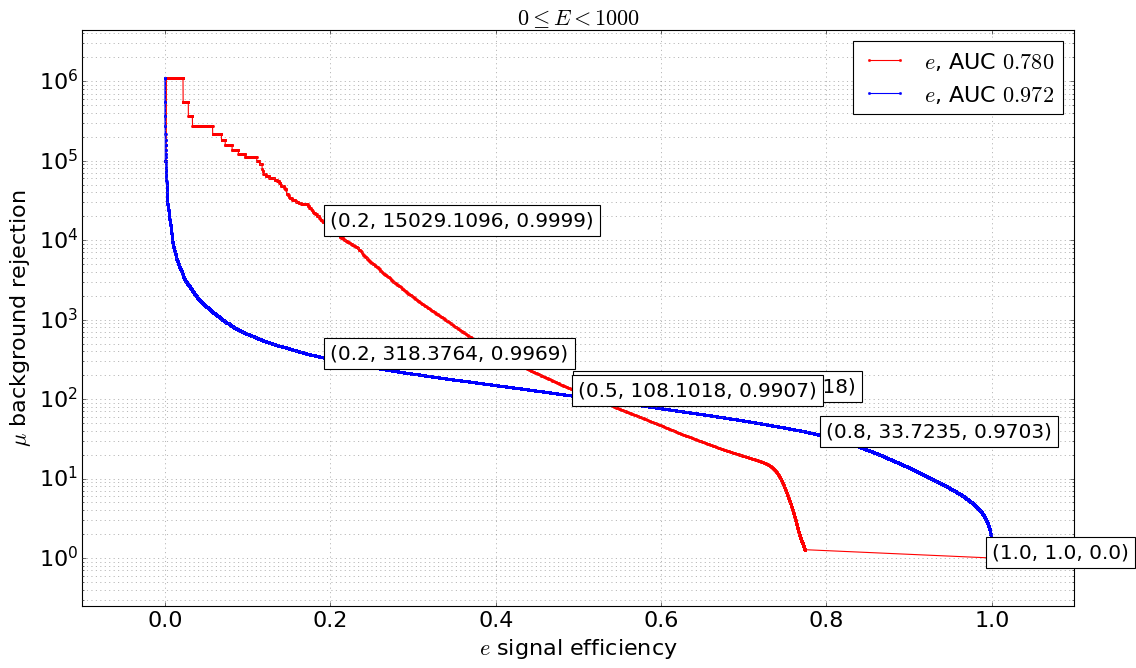

In [32]:
fprs = []
tprs = []
thresholds = []

fit_fpr, fit_tpr, fit_threshold = roc_curve(labels_e, diff_e)
fprs.append(fit_fpr)
tprs.append(fit_tpr)
thresholds.append(fit_threshold)

fprs.append(res_fpr)
tprs.append(res_tpr)
thresholds.append(res_threshold)

roc_metrics = plot_multiple_ROC(fprs, tprs, thresholds, "e", "mu", 0, 1000)

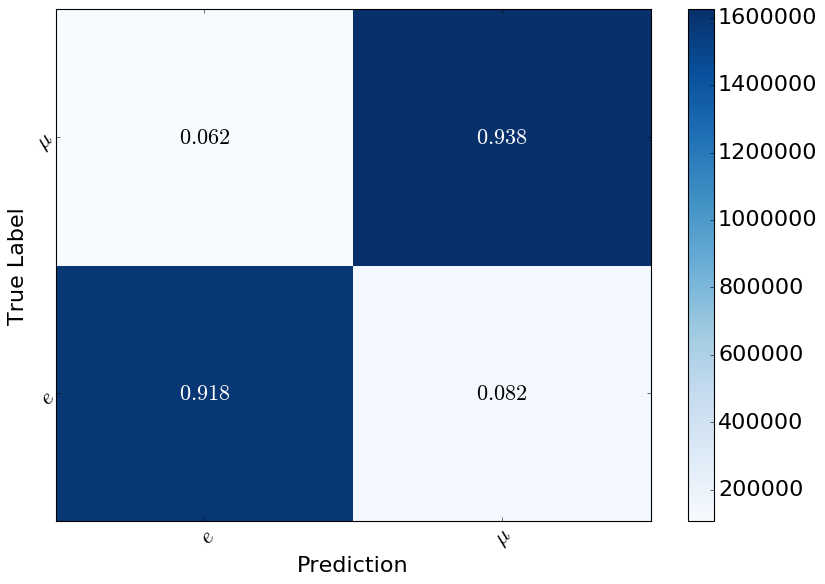

In [20]:
#diff_mu = np.concatenate((mu_nLL_diff_mu, e_nLL_diff_mu), axis=0)
#labels_mu = np.zeros(diff_mu.shape[0]).astype(int)
#diff_e = np.concatenate((mu_nLL_diff_e, e_nLL_diff_e), axis=0)
#labels_e = np.ones(diff_e.shape[0]).astype(int)

predictions_mu = np.zeros(labels_mu.shape[0]).astype(int)
predictions_e = np.ones(labels_e.shape[0]).astype(int)
predictions_mu[np.where(diff_mu <= 0)[0]] = 1
predictions_e[np.where(diff_e <= 0)[0]] = 0


predictions_total = np.concatenate((predictions_mu, predictions_e), axis=0)
labels_total = np.concatenate((labels_mu, labels_e), axis=0)

res_predictions_total = np.concatenate((e_predictedlabels, mu_predictedlabels, gamma_predictedlabels), axis=0)
res_labels_total = np.concatenate((e_labels, mu_labels, gamma_labels), axis=0)


plot_confusion_matrix(labels_total, predictions_total, ['$e$','$\mu$'])
#plot_confusion_matrix(res_labels_total, res_predictions_total, ['$\gamma$','$e$','$\mu$'])